In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data PreProcessing

## PreProcessing

> __Encoding__

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def preprocess_categorical_features(X):
    ''' Returns a new DataFrame with dummified columns'''
    cols=X.columns
    df=pd.DataFrame()
    for col in cols:
        df=pd.concat([df,pd.get_dummies(X[col],prefix=col)],axis=1)
    return df

> __Simple Imputer__

In [ ]:
from sklearn.impute import SimpleImputer

#Imputer replace NaNs with strategy value s
imputer = SimpleImputer(strategy = 'mean')
imputer.fit(data[[]])
df[] = imputer.transform(df[[]])

### Pipeline

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline preprocessing steps for "age": Impute then Scale
age_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

#putting all into a single preprocessor
preprocessor = ColumnTransformer([
      ('agetransformer', age_transformer, ['age']),
      ('onehotencoder', OneHotEncoder(), make_column_selector(dtype_include="object"))
])
    

# Pass the combined preprocessor into a Pipeline as a single step
final_pipe = Pipeline([
    ('preprocessing', preprocessor)
])

final_pipe.fit_transform(data)

> Pipelining a model

In [ ]:
final_pipe_model = Pipeline([
    ('preprocessing', preprocessor),
    ('linear_regression', LinearRegression())])

# Train pipeline
final_pipe_trained = final_pipe_model.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

# Make predictions
final_pipe_trained.predict(X_test.iloc[0:1])

> Cross validate a pipeline

In [ ]:
from sklearn.model_selection import cross_val_score

# Define X and y
X = data.drop(columns=['charges'])
y = data['charges']

# Cross validate pipeline
cross_val_score(final_pipe_model, X, y, cv=10, scoring='r2').mean()

## PCA ???? [NEED RECAP]
> Project the 3D data into a 2D plane to reduce the variance complexity. Then we ranked the variance to know the importance of different features.<br>
> - __does not improve all kinds of models__
> - __cannot handel NON-Linear relationship__
> - __work better with data already clustered__

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X)

pca.components_ # gives you all the PC 

Xp = pca.transform(X)
Xp

plt.scatter(Xp[:,0], Xp[:,1])

---------------------------

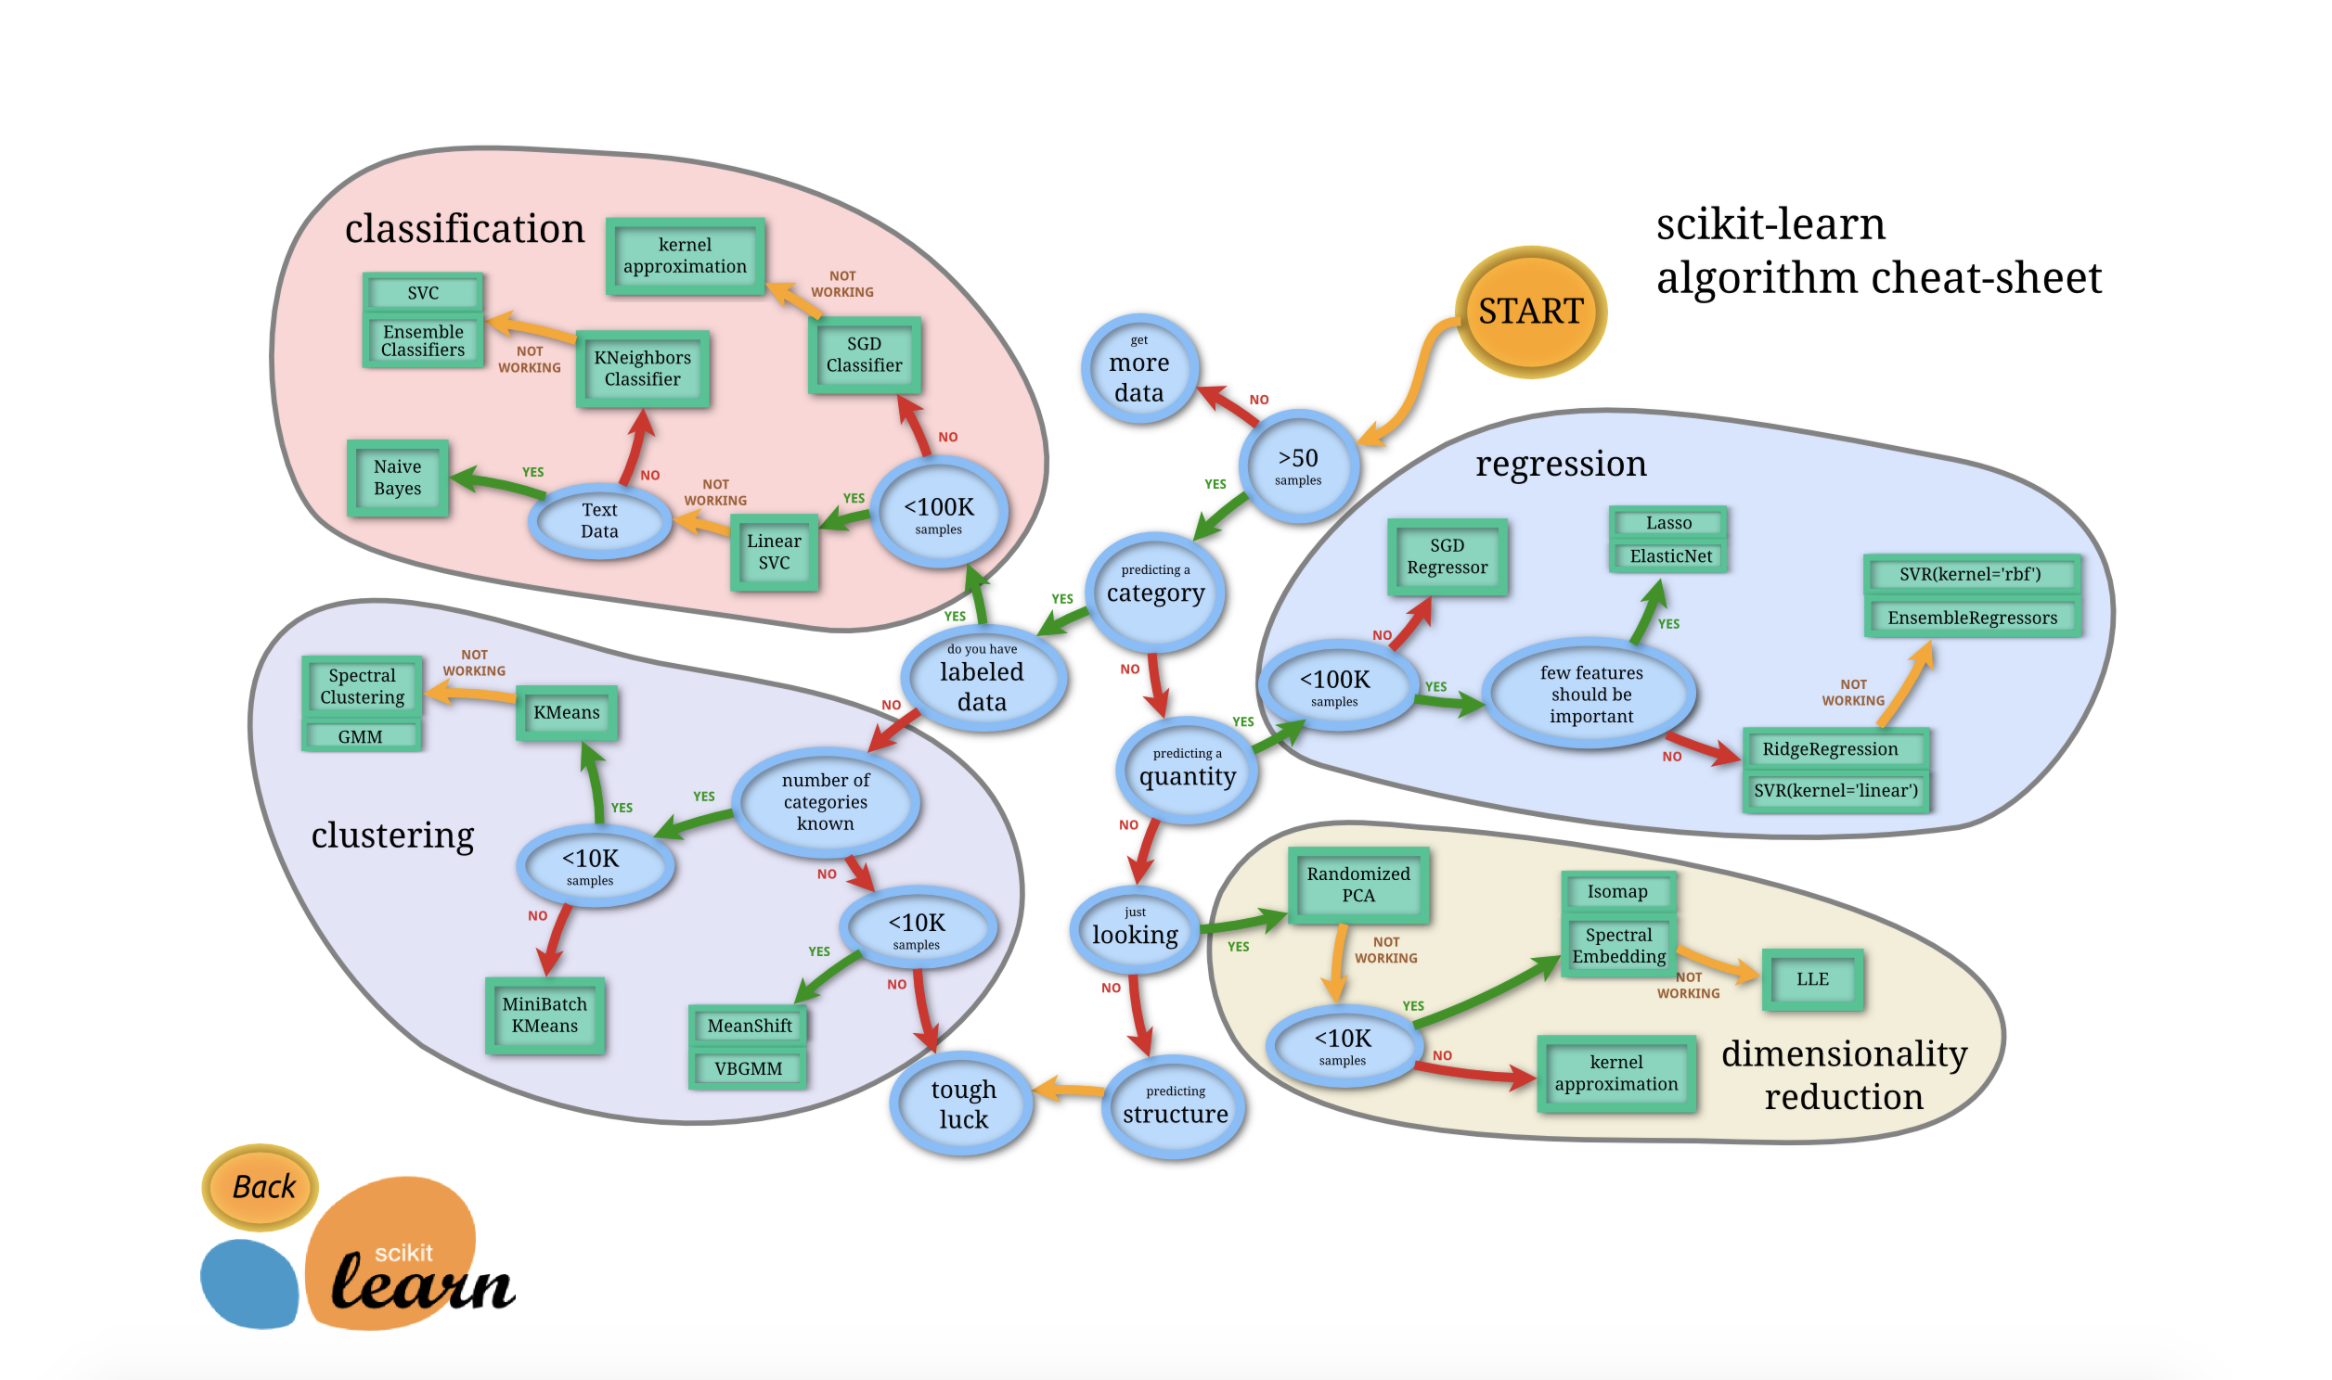

# Models

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 1)

## Baseline Score Test

In [ ]:
from sklearn.dummy import DummyRegressor

baseline_model = DummyRegressor(strategy = 'mean')

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X,y)

model.coef_ 
model.intercept_ 

# Evaluate the model's performance
model.score(X,y)

#  Predict on new data
model.predict([[1000]])

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Instanciate the model
log_model = LogisticRegression()

# Train the model on the data
log_model.fit(X, y)

# Evaluate the model's performance
log_model.score(X,y)

#  Predict on new data
log_model.predict([[1000]])

## KNN Regressor and Classifier

In [ ]:
# Import model

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Instanciate the model

K_class = KNeighborsClassifier()

# Train the model on the Training data

K_class.fit(X_train,y_train)

## SGDRegression and SGDClassifer

In [ ]:
from sklearn.linear_model import SGDRegressor, LinearRegression

lin_reg = LinearRegression() # OLS solved by matrix inversion (SVD method)

#SGDRegressor with LinearRegression Loss = squared_loss
lin_reg_sgd = SGDRegressor(loss='squared_loss') # OLS solved by SGD

lin_reg_sgd.fit(X,y)

## KMeans
> we cluster

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, random_state = 42).fit_predict(X)

#Plot the cluster
plt.scatter(X[:,0],X[:,1],c =kmeans)

---------------------------

# Model Tuning

## Lasso and Ridge

---------------------------------

# Evaluating the Model

## Learning Curve

In [ ]:
# Create empty dataframe to store scores
learning_curves_elements = pd.DataFrame(columns=['train_score', 'test_score', 'train_size'])

# Training set sizes to loop over
train_sizes = [50,100,200,300,400,500,600]

for size in train_sizes:
    
    # Sample the training set
    data_train_sample = data_train.sample(size, random_state = 5)
    
    # Prepare X and y
    X_train = data_train_sample[['surface']]
    y_train = data_train_sample['price']
    
    # Train the model on the sampled Train data
    model = LinearRegression().fit(X_train, y_train)

    # Score the model on the train data (sampled) and test data (fixed)
    test_score =   model.score(X_test,y_test)
    train_score =  model.score(X_train,y_train)
    
    # Append associated train score, test score, and train size to dataframe
    learning_curves_elements = learning_curves_elements.append({'train_score': train_score,
                                  'test_score': test_score,
                                  'train_size': size}, ignore_index=True)

In [ ]:
# Plot
import matplotlib.pyplot as plt

plt.plot(learning_curves_elements.train_size,learning_curves_elements.train_score,  color = 'red', label='train score')
plt.plot(learning_curves_elements.train_size,learning_curves_elements.test_score, color = 'blue', label='test score')
plt.title('Learning Curves')
plt.xlabel('train size')
plt.ylabel('R2 score')
plt.legend()
plt.show()

## Cross-Validate with Metrics

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

# 5-Fold Cross validate model
cv_results = cross_validate(LinearRegression(), X, y, cv=5,
                            scoring=['max_error','r2','neg_mean_absolute_error',
                                     'neg_mean_squared_error'])

# Cross validation output
pd.DataFrame(cv_results)

# Mean of scores
cv_results['test_score'].mean()

In [ ]:
from sklearn.model_selection import cross_val_predict

#only predict on the data that we've already have
#cannot predict unseen data
y_pred = cross_val_predict(model,X,y,cv = 5)

## ROC-AUC (Receiver Operating Characteristic-Area Under Curve)
> - Similar to the Precision/Recall curve, the ROC curve shows the tradeoff between two metrics at different decision thresholds.
> - The larger the AUC, the better the model

>__USE ROC over Preceision-Recal___ l when your dataset is balanced, as it considers both classes.<br>
> __Use Precision-Recall over ROC__ when your dataset is imbalanced, as you can focus on one class.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn. metrics import roc_auc_score

# Extract associated metrics and thresholds
fpr, tpr, thresholds = roc_curve(y_true, probabilities)

# Compute AUC score
auc_score = roc_auc_score(y_true, y_pred)

## Metrics

- classification -> accuracy
- regression -> mean absolute error

### Accuracy
> __The ratio of correct predictions__

> __USE MSE when__
> - Balanced classes
> - Prediction of each class is equally important

### Recall
> __Measures the ability of the model to detect occurences of a class.__

> __USE RMSE when__ It is important to identify as many occurences of a class as possible (E.g. Detecting Covid-19 infected people)

### Precision
> __Measures the ability of a model to avoid false alarms for a class.__

> __USE RMSE when__ e.x) Detecting a potential investment

### F1 Score
> __A combination of Precision and Recall into a single metric__

> __USE RMSE when__
> - You want to combine the Precision/Recall tradeoff in a single metric
> - You want a measure similar to accuracy but robust to class imbalance

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_scor
e, max_error
import math

mse = mean_squared_error(y, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
rsquared = r2_score(y, y_pred)
max_error = max_error(y, y_pred)

print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))
print('Max Error =', round(max_error, 2))